['Start Date: 2020-08-29', 'End Date: 2023-07-28', 'Stock: AAPL', 'Chart Type: Line Chart', 'Mark Anomalies: Yes', 'Model: VAE']
['Start Date: 2020-08-29', 'End Date: 2023-07-28', 'Stock: AAPL', 'Chart Type: Candlestick Chart', 'Mark Anomalies: Yes', 'Model: VAE']
['Start Date: 2017-08-29', 'End Date: 2023-07-28', 'Stock: ATO', 'Chart Type: Line Chart', 'Mark Anomalies: Yes', 'Model: VAE']
['Start Date: 2017-08-29', 'End Date: 2023-07-28', 'Stock: ATO', 'Chart Type: Line Chart', 'Mark Anomalies: Yes', 'Model: VAE']
['Start Date: 2017-08-29', 'End Date: 2023-07-28', 'Stock: ATO', 'Chart Type: Line Chart', 'Mark Anomalies: Yes', 'Model: VAE']


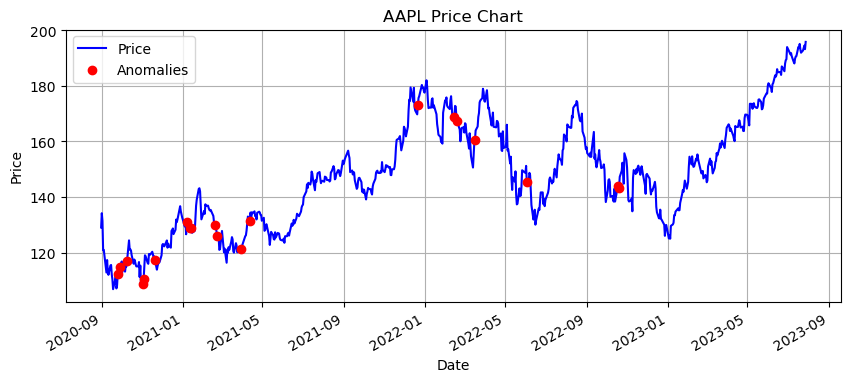

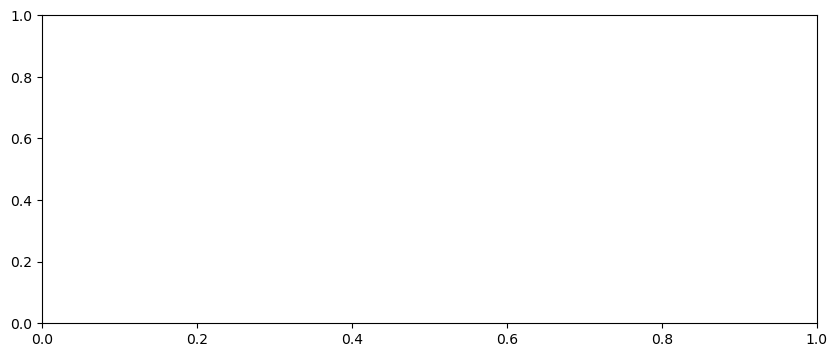

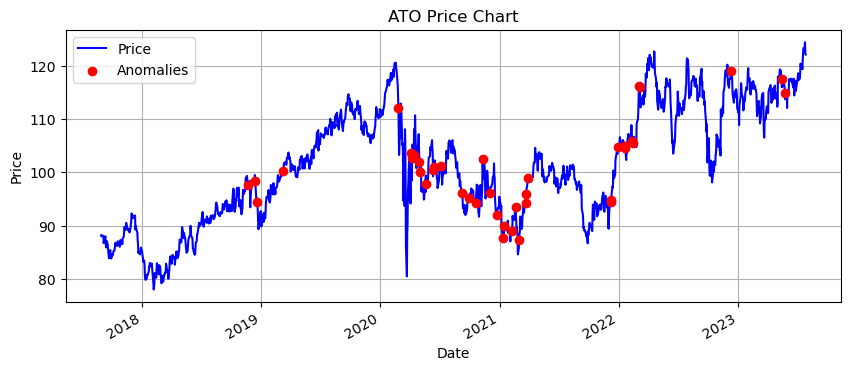

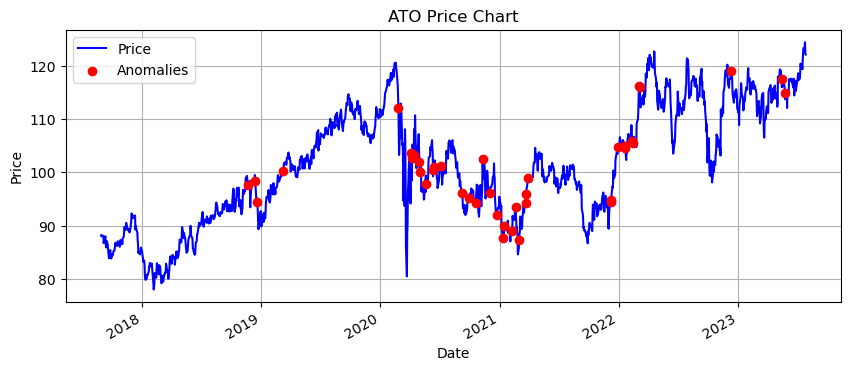

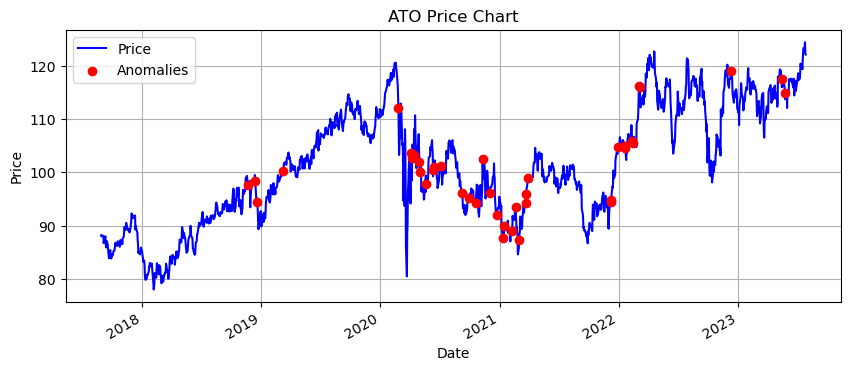

In [2]:
import tkinter as tk
from tkinter import ttk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

file_path = ["./Anomalies by VAE/anomalies_by_Communication Services.xlsx",
"./Anomalies by VAE/anomalies_by_Consumer Discretionary.xlsx",
'./Anomalies by VAE/anomalies_by_Consumer Staples.xlsx',
'./Anomalies by VAE/anomalies_by_Energy.xlsx',
'./Anomalies by VAE/anomalies_by_Financials.xlsx',
'./Anomalies by VAE/anomalies_by_Health Care.xlsx',
'./Anomalies by VAE/anomalies_by_Industrials.xlsx',
'./Anomalies by VAE/anomalies_by_Information Technology.xlsx',
'./Anomalies by VAE/anomalies_by_Materials.xlsx',
'./Anomalies by VAE/anomalies_by_Real Estate.xlsx',
'./Anomalies by VAE/anomalies_by_Utilities.xlsx']

file_path2 = ['./anomalies_by_sector/anomalies_by_Communication Services.xlsx',
'./anomalies_by_sector/anomalies_by_Consumer Discretionary.xlsx',
'./anomalies_by_sector/anomalies_by_Consumer Staples.xlsx',
'./anomalies_by_sector/anomalies_by_Energy.xlsx',
'./anomalies_by_sector/anomalies_by_Financials.xlsx',
'./anomalies_by_sector/anomalies_by_Health Care.xlsx',
'./anomalies_by_sector/anomalies_by_Industrials.xlsx',
'./anomalies_by_sector/anomalies_by_Information Technology.xlsx',
'./anomalies_by_sector/anomalies_by_Materials.xlsx',
'./anomalies_by_sector/anomalies_by_Real Estate.xlsx',
'./anomalies_by_sector/anomalies_by_Utilities.xlsx']



VAE_modle = {}
for i in file_path:
    excel_file = pd.ExcelFile(i)
    sheets_data = {sheet_name: excel_file.parse(sheet_name) for sheet_name in excel_file.sheet_names}
    VAE_modle.update(sheets_data)
iso_model ={}
for i in file_path2:
    excel_file = pd.ExcelFile(i)
    sheets_data = {sheet_name: excel_file.parse(sheet_name) for sheet_name in excel_file.sheet_names}
    iso_model.update(sheets_data)



aaaa = list(iso_model.keys())
stock_name_all = list(VAE_modle.keys())


def update_chart():
    # Retrieve user selections
    selections = get_selections()
    start_date = f"{start_year.get()}-{start_month.get()}-{start_day.get()}"
    end_date = f"{end_year.get()}-{end_month.get()}-{end_day.get()}"
    stock = stock_entry.get()
    chart_type = chart_entry.get()
    mark_anomalies = anomaly_entry.get() == "Yes"
    model = model_entry.get()

    # Validate inputs
    if not start_date or not end_date or not stock or not chart_type or not model:
        result_value.config(text="Please select all options", fg="red")
        return

    # Load data based on model selection
    data = None
    if model == "VAE":
        data = VAE_modle.get(stock)
    elif model == "Isolation Forest":
        data = iso_model.get(stock)

    if data is None:
        result_value.config(text="No data available for the selected stock/model", fg="red")
        return

    # Ensure "Dates" column is in datetime format
    data["Dates"] = pd.to_datetime(data["Dates"])

    # Filter data by date range
    mask = (data["Dates"] >= pd.to_datetime(start_date)) & (data["Dates"] <= pd.to_datetime(end_date))
    filtered_data = data.loc[mask]

    if filtered_data.empty:
        result_value.config(text="No data available in the selected date range", fg="red")
        return

    # Clear previous chart if any
    for widget in figure_frame.winfo_children():
        widget.destroy()

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 4))

    # Plot data based on chart type
    if chart_type == "Line Chart":
        ax.plot(filtered_data["Dates"], filtered_data["Price"], label="Price", color="blue")
    elif chart_type == "Candlestick Chart":
        try:
            from mplfinance.original_flavor import candlestick_ohlc
            import matplotlib.dates as mdates

            filtered_data["Dates"] = filtered_data["Dates"].apply(mdates.date2num)
            candlestick_ohlc(
                ax,
                filtered_data[["Dates", "Open", "High", "Low", "Close"]].values,
                width=0.6,
                colorup="green",
                colordown="red",
                alpha=0.8,
            )
        except ImportError:
            result_value.config(text="mplfinance is required for candlestick charts", fg="red")
            return

    # Mark anomalies if selected
    if mark_anomalies and "Anomaly Values" in filtered_data.columns:
        anomalies = filtered_data.dropna(subset=["Anomaly Values"])
        ax.scatter(anomalies["Dates"], anomalies["Price"], color="red", label="Anomalies", zorder=5)

    # Format the chart
    ax.set_title(f"{stock} Price Chart")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid(True)
    fig.autofmt_xdate()

    # Display the chart in the tkinter interface
    canvas = FigureCanvasTkAgg(fig, master=figure_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()



    # Example of adding data dynamically
    stock = stock_entry.get()
    model = model_entry.get()
    start_date = f"{start_year.get()}-{start_month.get()}-{start_day.get()}"
    end_date = f"{end_year.get()}-{end_month.get()}-{end_day.get()}"

    zz=1-sum(data['Anomaly Values'].isnull())/len(data)


    
    anomaly_rate = zz  # Replace with calculated anomaly rate
    add_row(stock, model, start_date, end_date, anomaly_rate)

    result_value.config(text=f"Chart updated and results added to table for {stock}", fg="green")
    

    # Update result metrics
    result_value.config(text=f"Displayed data for {stock} from {start_date} to {end_date}", fg="green")

# Create the main window
window = tk.Tk()
window.title("Stock Anomaly Interaction Interface")
window.geometry("1200x800")
window.configure(bg="#f0f0f0")  # Set a background color for a modern look

# Helper function to generate years, months, and days
years = [str(year) for year in range(2000, 2025)]
months = [f"{month:02d}" for month in range(1, 13)]
days = [f"{day:02d}" for day in range(1, 32)]

# Configure options row
options_frame = tk.Frame(window, bg="#f0f0f0")
options_frame.pack(pady=20)

# Start Date
start_label = tk.Label(options_frame, text="Start Date:", bg="#f0f0f0", font=("Arial", 16))
start_label.grid(row=0, column=0, padx=10)
start_year = ttk.Combobox(options_frame, values=years, width=5, font=("Arial", 14))
start_year.grid(row=0, column=1, padx=5)
start_month = ttk.Combobox(options_frame, values=months, width=3, font=("Arial", 14))
start_month.grid(row=0, column=2, padx=5)
start_day = ttk.Combobox(options_frame, values=days, width=3, font=("Arial", 14))
start_day.grid(row=0, column=3, padx=5)

# End Date
end_label = tk.Label(options_frame, text="End Date:", bg="#f0f0f0", font=("Arial", 16))
end_label.grid(row=0, column=4, padx=10)
end_year = ttk.Combobox(options_frame, values=years, width=5, font=("Arial", 14))
end_year.grid(row=0, column=5, padx=5)
end_month = ttk.Combobox(options_frame, values=months, width=3, font=("Arial", 14))
end_month.grid(row=0, column=6, padx=5)
end_day = ttk.Combobox(options_frame, values=days, width=3, font=("Arial", 14))
end_day.grid(row=0, column=7, padx=5)


# Frame for the result table (below the chart)
table_frame = tk.Frame(window, bg="#f0f0f0")
table_frame.pack(fill=tk.BOTH, expand=False, padx=10, pady=20)

# Scrollbars for the table
x_scrollbar = tk.Scrollbar(table_frame, orient=tk.HORIZONTAL)
x_scrollbar.pack(side=tk.BOTTOM, fill=tk.X)
y_scrollbar = tk.Scrollbar(table_frame, orient=tk.VERTICAL)
y_scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

# Create the table (Treeview) with a reduced width
columns = ("Stock Name", "Model Used", "Start Date", "End Date", "Anomaly Rate (%)")
table = ttk.Treeview(
    table_frame, 
    columns=columns, 
    show="headings", 
    xscrollcommand=x_scrollbar.set, 
    yscrollcommand=y_scrollbar.set,
    selectmode="browse",
    height=3  # Reduce the height of the table
)
table.pack(side=tk.LEFT, fill=tk.BOTH, expand=False)

# Configure scrollbars
x_scrollbar.config(command=table.xview)
y_scrollbar.config(command=table.yview)

# Define column headers with adjusted widths
for col in columns:
    table.heading(col, text=col)
    table.column(col, width=120, anchor="center")  # Adjust column width

# Add row to the table dynamically
def add_row(stock, model, start_date, end_date, anomaly_rate):
    table.insert("", tk.END, values=(stock, model, start_date, end_date, f"{anomaly_rate:.2f}"))

# Delete selected row
def delete_row():
    selected_item = table.selection()
    if selected_item:
        table.delete(selected_item[0])

# Add a delete button to the right of the table
delete_button = tk.Button(
    table_frame, 
    text="Delete Selected Row", 
    command=delete_row, 
    bg="#d9534f", 
    fg="white", 
    font=("Arial", 14)
)
delete_button.pack(side=tk.RIGHT, padx=10, pady=10)


'''
stock_label = tk.Label(options_frame, text="Stock Selection:", bg="#f0f0f0", font=("Arial", 16))
stock_label.grid(row=1, column=0, padx=10, pady=10)
stock_entry = ttk.Combobox(options_frame, values=stock_name_all, width=10, font=("Arial", 14))
stock_entry.grid(row=1, column=1, padx=10, pady=10)
'''
# Stock Selection
stock_label = tk.Label(options_frame, text="Stock Selection:", bg="#f0f0f0", font=("Arial", 16))
stock_label.grid(row=1, column=0, padx=10, pady=10)

# Define a function to filter stock names based on input
def filter_stock_names(event):
    input_text = stock_entry.get().lower()  # Get the current input text and convert to lowercase
    filtered_names = [name for name in stock_name_all if name.lower().startswith(input_text)]  # Filter names
    stock_entry["values"] = filtered_names  # Update the Combobox dropdown values
    stock_entry.event_generate("<Down>")  # Open the dropdown automatically

# Create the Combobox
stock_entry = ttk.Combobox(options_frame, width=10, font=("Arial", 14))
stock_entry["values"] = stock_name_all  # Initialize with all stock names
stock_entry.grid(row=1, column=1, padx=10, pady=10)

# Bind the key release event to dynamically filter the dropdown
stock_entry.bind("<KeyRelease>", filter_stock_names)


# Chart Type
chart_label = tk.Label(options_frame, text="Chart Type:", bg="#f0f0f0", font=("Arial", 16))
chart_label.grid(row=1, column=2, padx=10)
chart_entry = ttk.Combobox(options_frame, values=["Line Chart", "Candlestick Chart"], width=15, font=("Arial", 14))
chart_entry.grid(row=1, column=3, padx=10)

# Anomaly Marking
anomaly_label = tk.Label(options_frame, text="Mark Anomalies:", bg="#f0f0f0", font=("Arial", 16))
anomaly_label.grid(row=1, column=4, padx=10)
anomaly_entry = ttk.Combobox(options_frame, values=["Yes", "No"], width=5, font=("Arial", 14))
anomaly_entry.grid(row=1, column=5, padx=10)

# Model Selection
model_label = tk.Label(options_frame, text="Model:", bg="#f0f0f0", font=("Arial", 16))
model_label.grid(row=1, column=6, padx=10)
model_entry = ttk.Combobox(options_frame, values=["VAE", "Isolation Forest"], width=15, font=("Arial", 14))
model_entry.grid(row=1, column=7, padx=10)

# Function to collect selections
def get_selections():
    selections = [
        f"Start Date: {start_year.get()}-{start_month.get()}-{start_day.get()}",
        f"End Date: {end_year.get()}-{end_month.get()}-{end_day.get()}",
        f"Stock: {stock_entry.get()}",
        f"Chart Type: {chart_entry.get()}",
        f"Mark Anomalies: {anomaly_entry.get()}",
        f"Model: {model_entry.get()}"
    ]
    print(selections)  # For debugging purposes, prints to the console
    return selections

# Chart display area
figure_frame = tk.Frame(window, bg="#f0f0f0")
figure_frame.pack(pady=20)

    
    
# Button to update chart
update_button = tk.Button(window, text="Update Chart", command=update_chart, bg="#007acc", fg="white", font=("Arial", 16))
update_button.pack(pady=20)

# Result metrics display area
results_frame = tk.Frame(window, bg="#f0f0f0")
results_frame.pack(pady=20)

result_label = tk.Label(results_frame, text="Result Metrics:", bg="#f0f0f0", font=("Arial", 18, "bold"))
result_label.pack()
result_value = tk.Label(results_frame, text="Metrics will be displayed here", bg="#f0f0f0", font=("Arial", 14))
result_value.pack()

# Run the main loop
window.mainloop()
